# Geochemical Facies Analysis - Writeup

Introduction


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans

# Visualization libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

## XRF Cuttings Analysis

- Cuttings analysis overview
- XRF - what/how it does measurements

X-Ray Flourescence (XRF) is a non-destructive measurement technique
- measure the flourescent x-rays emitted by a sample when illuminated by an X-ray source
- elements in the sample will emit X-rays certain specific wavelengths
- the emitted x-rays can be measured and used to quantify the amount of the corresponding element in present in the sample

## Data Exploration
- loading the data
- cleaning the data
- visualizing the data

In [2]:
geochem_df = pd.read_csv('XRF_Cuttings_Analysis.csv')

# delete the first row that has units
geochem_df.drop(geochem_df.index[0], inplace=True)

#drop empty rows
geochem_df = geochem_df[pd.notnull(geochem_df['Quartz'])]

#drop some redundant rows
geochem_df.drop(['Kaolinite', 'Total Carbonate', 'Total Feldspar', 'Total Clay'], axis=1, inplace=True)

#remove white space from some column names
cols = geochem_df.columns.tolist()
cols = map(lambda s: s.strip(), cols)
geochem_df.columns = cols

# rename some columns
geochem_df.rename(columns={'Depth (m)': 'Depth'}, inplace=True)

#convert all numeric columns, nan if missing data
for col in  geochem_df.columns[2:]:
    geochem_df[col] = pd.to_numeric(geochem_df[col], errors='coerce')

#drop all nan columns and rows
geochem_df.dropna(axis=1, how='all', inplace=True)
geochem_df.dropna(axis=0, how='all', inplace=True)
  
# interpolate remaining missing values
geochem_df = geochem_df.interpolate()

geochem_df.reset_index(drop=True, inplace=True)

geochem_df.describe()

,Depth,Quartz,K-Feldspar,Plagioclase,Chlorite,IlliteSmectiteMica,Calcite,Ankerite/Dolomite,Pyrite,Organics,...,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SO3,Cl,Zr
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,...,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,4154.480567,42.273057,2.003360,5.717591,2.267126,11.361538,28.947530,4.040850,1.536336,1.828138,...,1.764302,0.178300,0.503026,18.680455,0.675729,0.899879,0.102915,0.964028,0.094970,195.844666
std,912.735534,6.130054,1.391134,2.679528,0.962211,5.695106,8.658077,2.480003,0.507179,0.898387,...,0.640452,0.094186,0.758595,6.822604,0.214603,0.386979,0.087059,0.315572,0.064297,84.551862
min,2945.370000,18.100000,0.000000,0.000000,0.240000,0.000000,8.070000,0.000000,0.340000,0.000000,...,0.380000,0.010000,0.010000,6.170000,0.160000,0.250000,0.000000,0.290000,0.010000,38.480000
25%,3420.860000,38.805000,0.940000,3.820000,1.582500,6.897500,22.792500,2.052500,1.240000,1.210000,...,1.370000,0.140000,0.130000,13.420000,0.550000,0.620000,0.060000,0.732500,0.050000,136.075000
50%,3888.725000,42.020000,1.950000,5.625000,2.045000,10.870000,28.150000,3.910000,1.510000,1.830000,...,1.690000,0.180000,0.290000,18.545000,0.640000,0.855000,0.080000,0.965000,0.070000,190.695000
75%,4759.692500,46.175000,2.905000,7.492500,2.920000,14.617500,33.767500,5.695000,1.780000,2.440000,...,2.010000,0.210000,0.490000,22.297500,0.750000,1.090000,0.110000,1.160000,0.117500,240.232500
max,6296.640000,56.740000,6.520000,13.740000,6.950000,32.680000,58.780000,11.950000,6.040000,5.570000,...,4.430000,1.250000,3.690000,41.940000,1.550000,2.430000,1.040000,2.850000,0.370000,472.940000


## Feature Engineering

What is feature engineering?

Geochemical elements are used as proxies that give hints to the physical, chemical or biological events that were occuring during its formation.  Ratios of certain elements can indicate the relative strength of various effects.
- Zr is a proxy for detrital input
- Si/Zr - used to record high biogenic silica relative to detrital input
- Si/Al - used as a proxy for biogenic production, aluminous clay (Croudace and Rothwell, 2015)
- Zr/Al - proxy for terrigenous input, geochemical behavior of Zr suggests that this ratio can be used as a proxy for grain size (Calvert and Pederson, 2007).

In [3]:
geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

## Dimensionality Reduction

The practice of extracting insights from large datasets has certainly caught mainstream attention in recent years.  Terms like 'Big Data' and 'multivariate statistics' pervade industry literature and conference show floors.  Geoscientists, however, have been wrangling massive multivariate datasets since the first seismic survey. While there have been recent advances in machine learning (eg. deep neural networks) many of the multivariate approaches to learning from data have been around for a long time. There are also a plethora of libraries available that implement these methods.

Not surprisingly, multivariate datasets are characterized by the fact that they contain plenty of variables.  This richness can be used to explain complex behaviour that can't be captured with a single observation.  Multivariate methods allow us to consider changes in several observations simultaneously.  With many observations it is quite likely that the changes we observe are related to a smaller number of underlying causes.  Dimensionality Reduction is the process of using the correlations in the observed data to reveal a more parsimonious underlying model that explains the variation in the observed data.

Exploratory factor analysis (EFA) reduces the number of variables by identifying the underlying *latent factors* present in the dataset.  These factors cannot be measured directly, can be determined only by measuring manifest properties.  For example, in the case of our geochemical dataset, a *shaliness* factor could be associated with high XX and XX readings. EFA assumes that the observations are a linear combination of the underlying factors, plus some Gaussian noise.    A related dimensionality reduction technique is principle component analysis (PCA).  In EFA, the factors are responsible for causing the responses in the measured variables.  PCA determines components that are weighted linear combinations of the observations. 

Before applying EFA, the dataset should be standardized.  If the measurements were made using different scales, this can affect the weights assigned to each factor.  This preprocessing operation rescales each variable to have zero mean and unit variance. 

In [4]:
data = geochem_df.ix[:, 2:]
data = scale(data)

EFA requires that the number of factors to be extracted is specified *a-priori*.  It is often not immediately obvious how many factors should be specified.  Many authors have proposed rules over the years (eg. Preacher et al, 2013).  One simple approach (known as the Kaiser criterion) involves looking at the eigenvalues of the covariance matrix of the data, and counting the number above a threshold (typically 1.0).  In the Figure , there are 7 eigenvalues greater than 1.0 (dashed red line), suggesting the number of factors to be extracted.

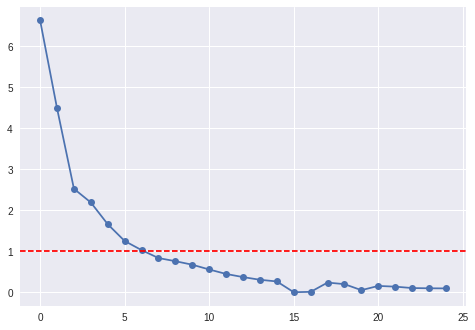

In [5]:
fig = plt.figure()
plt.plot(np.linalg.eig(np.cov(data, rowvar=False))[0], 'o-')
#plt.title('Eigenvalues of covariance matrix')
plt.axhline(y=1.0, color='r', linestyle='--')
fig.savefig('images/1_eigs.png', dpi=300, bbox_inches='tight')

The scikit-learn library contains a FactorAnalysis module that can be used to extract the 7 factors.

In [6]:
fa_model = FactorAnalysis(n_components = 7)
fa_model.fit(data)
factor_data = fa_model.transform(data)

In [7]:
# create a dataframe consisting of the factor values for each data point
factor_df = pd.DataFrame(factor_data, columns=['Comp {}'.format(i) for i in range(0,7)])
factor_df['Well Name'] = geochem_df['Well Name']
factor_df['Depth'] = geochem_df['Depth']

# create a dataframe with the factor loadings associated with each observation
factors =  pd.DataFrame(fa_model.components_, columns=geochem_df.ix[:, 2:].columns.values)

### Interpreting the factors

The factors can now be examined to interpret the underlying properties they represent.  Figure X shows the *factor loadings* associated with the first factor.  The loading score indicates the correlation between the factor and the observed variable.  In this case, the first factor is associated with high values of Calcite, Dolomite and CaO.  We could interpret this factor as representing the carbonate character of the rock.  Similar interpretations can be given to the other factors by observing their loading scores.

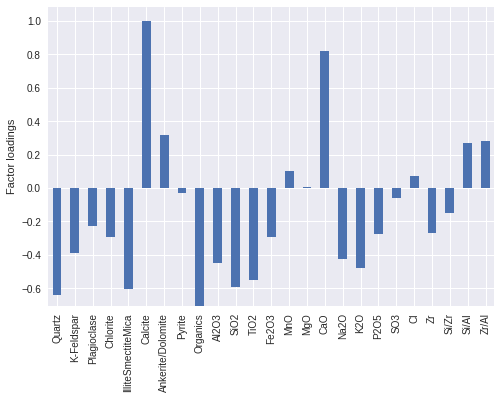

In [8]:
for factor_id in range(0, factors.shape[0]):
    fig = plt.figure()
    #plt.title('Factor {}'.format(factor_id))
    plt.ylabel('Factor loadings')
    factors.ix[factor_id].plot(kind='bar')
    if factor_id == 0:
        fig.savefig('images/2_Factor_interp.png', dpi=300, bbox_inches='tight')
        break

## Clustering
   
The factor analysis has reduced the initial collection of 25 XRF features in a reduced set of 7 factors that account for most of the variation in the data.  A logical next step would be using these factors to group the cutting samples by rock type, or *geochemical facies*.  Cluster analysis is a suitable approach for using these factors to assign a common facies label to similar  samples. Clustering attempts to group samples so that those in the same group (or cluster) are more similar than those in other clusters.  Cluster analysis is one class of techniques that fall under the category of *unsupervised* machine learning.  These approaches are used to infer structure from the data itself, without the use of labeled training data to guide the model. 

The kmeans(http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm clusters data by trying to separate samples in $n$ groups of equal variance.  The algorithm locates the optimal cluster centroids by minimizing the distance between each point in a cluster and the closest centroid. The algorithm has three steps.  It initializes by picking locations for the initial $n$ centroids (often random samples from the dataset).  Next, each sample is assigned to one of the $n$ groups according to the nearest centroid.  New centroids are then calculated by finding the mean values of each sample in each group.  This is repeated until the difference between subsequent centroid positions falls below a given threshold.

- talk about the analysis, why are we choosing 7 means?

In [9]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(factor_data)
factor_df['Cluster'] = kmeans.labels_
geochem_df['Cluster'] = factor_df['Cluster']

### Interpreting the clusters

Explain the factor components

Explain the box plot

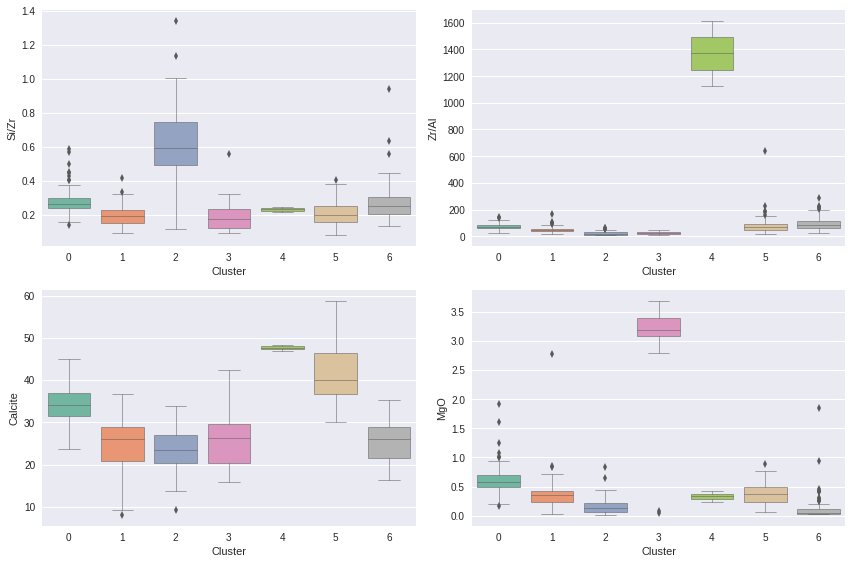

In [10]:
#get this down to 4 plots
# facies_colors = ['#DA9F8A', '#E48C50','#8E8E68','#88A64C',
#        '#5FBBB1','#00A7CB', '#3974AA']

facies_colors = sns.color_palette("Set2", 8)
del facies_colors[5]

fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.boxplot(x='Cluster', y='Si/Zr', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
sns.boxplot(x='Cluster', y='Zr/Al', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
sns.boxplot(x='Cluster', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[1,0],
            palette=facies_colors)
sns.boxplot(x='Cluster', y='MgO', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)

plt.tight_layout()
fig.savefig('images/3_Cluster_fingerprint.png', dpi=300, bbox_inches='tight')

## Visualizing results
- vertical log plots of wells
- trajectory plots

- conclusions, where to go for more info, links to repos, etc.

In [11]:
def make_facies_log_plot(logs, facies_colors, label):
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 10))
    ax[0].plot(logs['Si/Zr'], logs.Depth, '-g')
    ax[1].plot(logs['Zr/Al'], logs.Depth, '-')
    ax[2].plot(logs['Calcite'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['MgO'], logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((14*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6', 'Clust 7']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("Si/Zr")
    ax[0].set_xlim(logs['Si/Zr'].min(),logs['Si/Zr'].max())
    ax[0].set_ylabel('MD [m]')
    ax[0].grid(b=False)
    ax[1].set_xlabel("Zr/Al")
    ax[1].set_xlim(logs['Zr/Al'].min(),logs['Zr/Al'].max())
    ax[1].grid(b=False)
    ax[2].set_xlabel("Calcite")
    ax[2].set_xlim(logs['Calcite'].min(),logs['Calcite'].max())
    ax[2].grid(b=False)
    ax[3].set_xlabel("MgO")
    ax[3].set_xlim(logs['MgO'].min(),logs['MgO'].max())
    ax[3].grid(b=False)
    ax[4].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    #f.suptitle(logs.iloc[0]['Well Name'], fontsize=14,y=0.9)
    return f

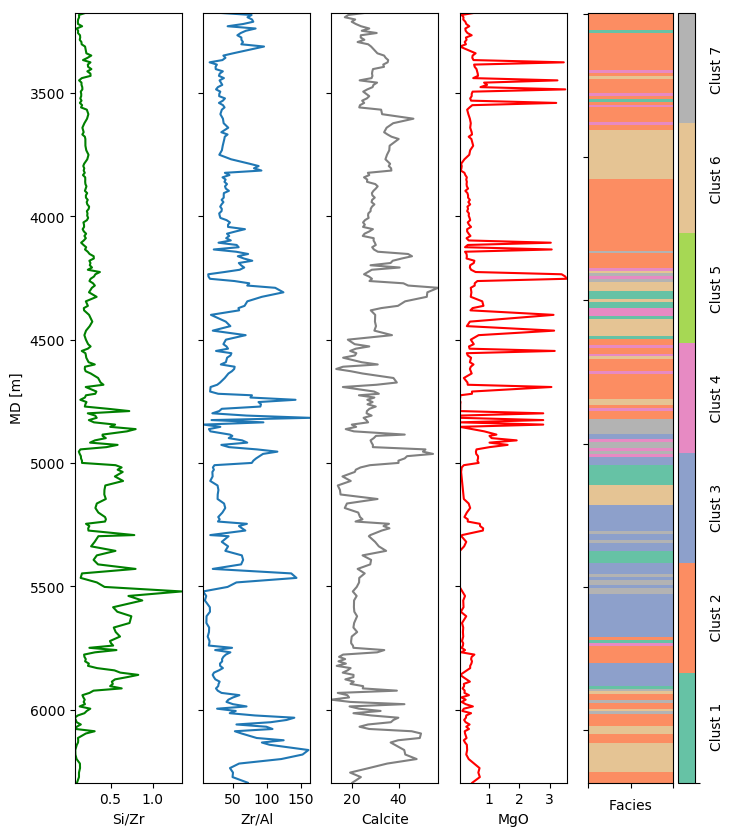

In [12]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f = make_facies_log_plot(geochem_df[geochem_df['Well Name'] == 'Well 1'],
        facies_colors, 'Cluster')
f.savefig('images/4_Well1_logs.png', dpi=300, bbox_inches='tight')

In [13]:
filename = 'well_trajectory.csv'
trajectory_df = pd.read_csv(filename)

# combine the stat facies curve 
well1_df = geochem_df[geochem_df['Well Name'] == 'Well 1']

In [14]:
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
x = trajectory_df.MD.values
y = trajectory_df.TVD.values
f = interp1d(x,y)

well1_df = well1_df.assign(TVD = f(well1_df.Depth.values))

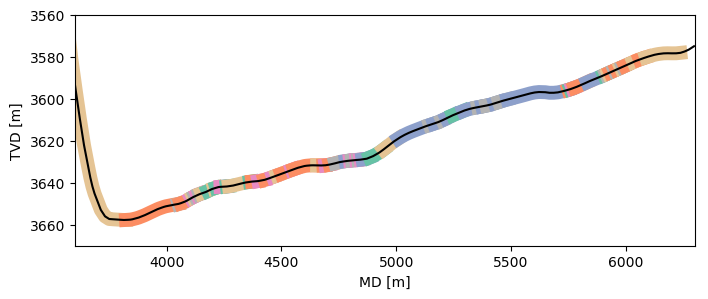

In [15]:
last_row = len(well1_df)
fig = plt.figure(figsize=(8,3))

x = []
y = []
for index, row in well1_df.iterrows():
    if index == last_row-1:
        break
    next_row = well1_df.ix[index+1]
    current_facies = row['Cluster']
    next_facies = well1_df.ix[index+1, 'Cluster']
    #print('current: %d, next: %d\n'%(current_facies, next_facies))
    x.append(row.Depth)
    y.append(row.TVD)
    if current_facies != next_facies:
        x.append(next_row.Depth)
        y.append(next_row.TVD)
        plt.plot(x,y,color=facies_colors[current_facies],linewidth=10)
        x = []
        y = []
plt.xlim([3600, 6300])
plt.ylim([3560, 3670])
plt.gca().invert_yaxis()

plt.plot(well1_df.Depth, well1_df.TVD, color='k',label='Well 1')
#plt.title('Well 1')
plt.xlabel('MD [m]')
plt.ylabel('TVD [m]')
plt.show()
fig.savefig('images/5_Well1_trajectory.png', dpi=300, bbox_inches='tight')

## References

Croudace, I. W., and R. G. Rothwell. *Micro-XRF Studies of Sediment Cores*. Springer, 2015.

Calvert, S. and Pedersen, T. (2007). *Elemental proxies for paleoclimatic and palaeoceanographic variability in marine sediments: interpretation and application*. Developments in Marine Geology. 1. 568-644. 

Davis, J. C. *Statistical and Data Analysis in Geology*. J. Wiley, 1986.

Iwamori, H., Yoshida, K., Nakamura, H. Kuwatani, T., Hamada, M., Haraguchi, S. and Ueki, K. (2017) *Classification of geochemical data based on multivariate statistical analyses: Complementary roles of cluster, principal component, and independent component analyses*. Geochemisty, Geophysics, Geosystems. 18(3).  994–1012. doi:[10.1002/2016GC006663](http://onlinelibrary.wiley.com/doi/10.1002/2016GC006663/abstract)

Preacher K.J., Zhang G., Kim C. and Mels G. (2013) *Choosing the Optimal Number of Factors in Exploratory Factor Analysis: A Model Selection Perspective*. Multivariate Behav Res. 48(1).